In [1]:
import glob
import shutil
import os
import random
from PIL import Image

import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,StratifiedKFold

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications.vgg19 import VGG19

import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

C:\Users\82108\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


### preprocessing xcf file

In [2]:
import layeredimage.io

In [88]:
image_dir = './real_data/'
ROOT_DIR = os.path.dirname(image_dir)
IMG_DIR = os.path.join(ROOT_DIR, "img")
MSK_DIR = os.path.join(ROOT_DIR, "msk")
IMG_RESIZE_DIR = os.path.join(ROOT_DIR, "img_resize")
MSK_RESIZE_DIR = os.path.join(ROOT_DIR, "msk_resize")
IMG_MODIFY_DIR = os.path.join(ROOT_DIR, "img_modify")
MSK_MODIFY_DIR = os.path.join(ROOT_DIR, "msk_modify")

os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MSK_DIR, exist_ok=True)
os.makedirs(IMG_RESIZE_DIR, exist_ok=True)
os.makedirs(MSK_RESIZE_DIR, exist_ok=True)
os.makedirs(IMG_MODIFY_DIR, exist_ok=True)
os.makedirs(MSK_MODIFY_DIR, exist_ok=True)

###### 확장자에 따라 폴더 이동

In [23]:
img_list = glob.glob(image_dir+'*.png')

In [29]:
img_list = glob.glob(image_dir+'*.png')
new_img_list = [_.replace('\\', '\\img\\') for _ in img_list]
for from_, to_ in zip(img_list, new_img_list):
    os.rename(from_, to_)

In [30]:
img_list = glob.glob(image_dir+'*.jpg')
new_img_list = [_.replace('\\', '\\img\\') for _ in img_list]
for from_, to_ in zip(img_list, new_img_list):
    os.rename(from_, to_)

In [31]:
msk_list = glob.glob(image_dir+'*.xcf')
new_msk_list = [_.replace('\\', '\\msk\\') for _ in msk_list]
for from_, to_ in zip(msk_list, new_msk_list):
    os.rename(from_, to_)

###### xcf to png

In [41]:
for msk in tqdm_notebook(new_msk_list):
    xcf = layeredimage.io.openLayerImage(msk)
    xcf.getFlattenLayers().save(msk.split('.xcf')[0] + '.png')

###### 공통된 파일명만 교집합 처리

In [101]:
#실제 데이터
img = glob.glob(IMG_DIR + '/*')
msk = glob.glob(MSK_DIR + '/*png')

In [102]:
len(img), len(msk)

(2088, 2085)

In [103]:
img_name = [_.split('\\')[-1].split('.')[0] for _ in img]
msk_name = [_.split('\\')[-1].split('.')[0] for _ in msk]

In [104]:
set(img_name) - set(msk_name) #이미지만 있고 마스크가 없는 이미지명

{'공연운63', '박미경4 (99', '변수진48'}

In [105]:
matchers = list(set(img_name) - set(msk_name))
except_img = [s for s in img if any(xs in s for xs in matchers)]

In [106]:
img = list(set(img) - set(except_img))

In [107]:
len(img), len(msk)

(2085, 2085)

In [108]:
img = sorted(img)
msk = sorted(msk)

###### img의 검정 테두리 제거

In [109]:
for _img, _msk in tqdm_notebook(zip(img, msk)):
    image = cv2.imdecode(np.fromfile(_img, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    mask= cv2.imdecode(np.fromfile(_msk, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    _w, _h = 0, 0
    for _ in range(len(contours)):
        cnt = contours[_]
        x,y,w,h = cv2.boundingRect(cnt)
        if (_w < w)&(_h < h):
            image_crop = image[y:y+h,x:x+w]
            mask_crop = mask[y:y+h,x:x+w]
            _w, _h = w, h
    __img = Image.fromarray(image_crop)
    __msk = Image.fromarray(mask_crop) 
    __img.save(os.path.join(IMG_MODIFY_DIR, _img.split('\\')[-1]))
    __msk.save(os.path.join(MSK_MODIFY_DIR, _msk.split('\\')[-1]))

###### 이미지 크기 통일

In [110]:
#실제 데이터
img = glob.glob(IMG_MODIFY_DIR + '/*')
msk = glob.glob(MSK_MODIFY_DIR + '/*')

In [111]:
len(img), len(msk)

(2085, 2085)

In [112]:
def normalize(x):
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))

In [ ]:
for _ in tqdm_notebook(img):
    _img = cv2.resize(plt.imread(_) , dsize=(512, 512), interpolation=cv2.INTER_AREA)
    _img = normalize(_img)
    plt.imsave(IMG_RESIZE_DIR + '\\' + _.split('\\')[-1].split('.')[0] + '.png', _img)

In [ ]:
for _ in tqdm_notebook(msk):
    _img = cv2.resize(plt.imread(_) , dsize=(512, 512), interpolation=cv2.INTER_AREA)
    _img = normalize(_img)
    plt.imsave(MSK_RESIZE_DIR + '\\' + _.split('\\')[-1].split('.')[0] + '.png', _img)

###### train, test구분

In [73]:
img = glob.glob(IMG_RESIZE_DIR + '/*')
msk = glob.glob(MSK_RESIZE_DIR + '/*')

In [74]:
len(img), len(msk)

(2085, 2085)

In [75]:
img = sorted(img)
msk = sorted(msk)

In [76]:
elements = len(msk)
middle = int(elements * 0.7)

# train_x = img[:middle]
# train_y = msk[:middle]

# test_x = img[middle:]
# test_y = msk[middle:]

train_x = img[:160]
train_y = msk[:160]

test_x = img[160:200]
test_y = msk[160:200]

In [77]:
len(train_x), len(train_y), len(test_x), len(test_y)

(160, 160, 40, 40)

In [78]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    #img = tf.image.resize(img, (960,1280))
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    #mask = tf.image.resize(mask, (960,1280))
    
    return img, mask / 255

dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = dataset.map(process_path)

val_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y))
val_ds = val_ds.map(process_path)

(512, 512, 3) 255
(512, 512, 1) 1.0


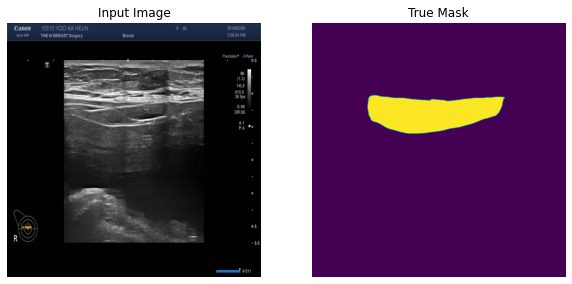

(512, 512, 3) 255
(512, 512, 1) 1.0


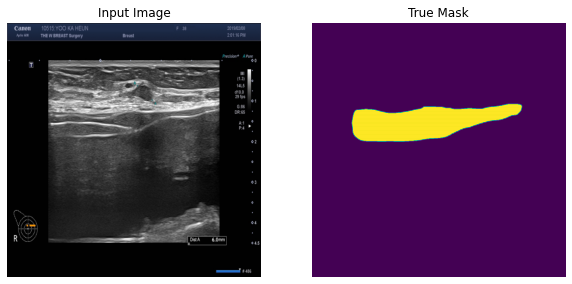

(512, 512, 3) 255
(512, 512, 1) 1.0


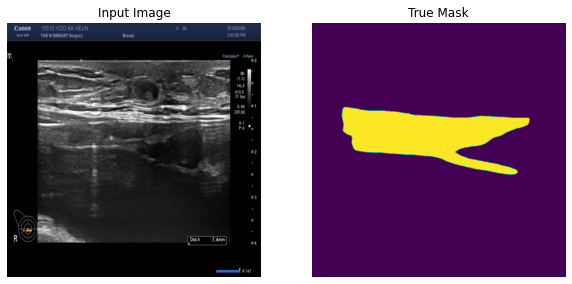

(512, 512, 3) 255
(512, 512, 1) 1.0


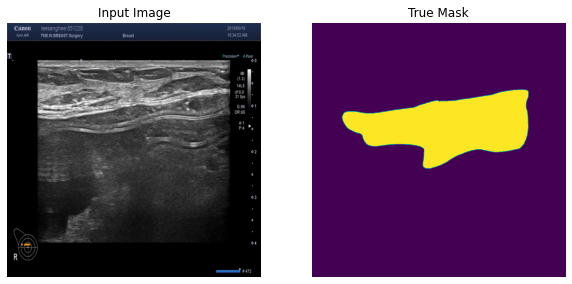

(512, 512, 3) 255
(512, 512, 1) 1.0


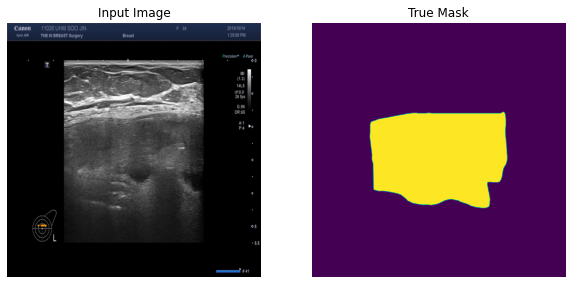

(512, 512, 3) 255
(512, 512, 1) 1.0


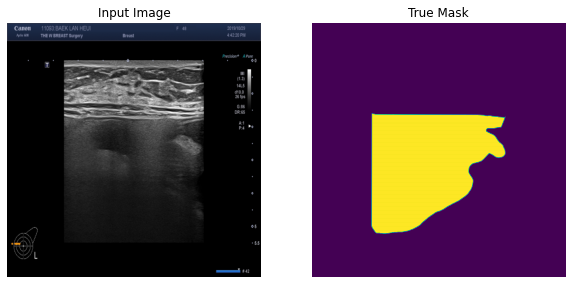

(512, 512, 3) 255
(512, 512, 1) 1.0


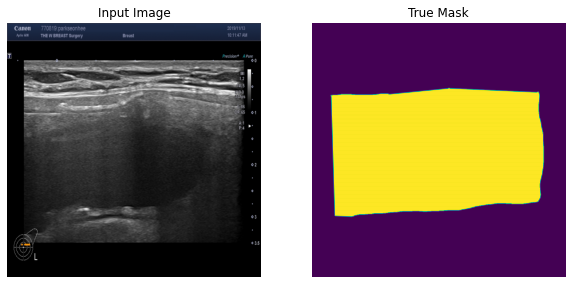

(512, 512, 3) 255
(512, 512, 1) 1.0


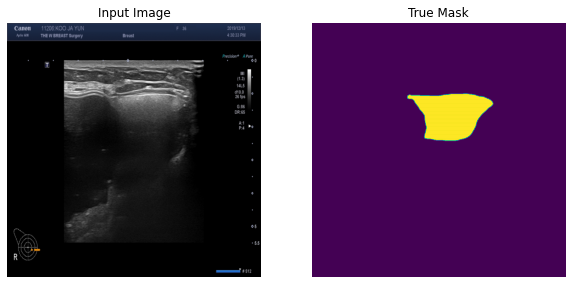

(512, 512, 3) 255
(512, 512, 1) 1.0


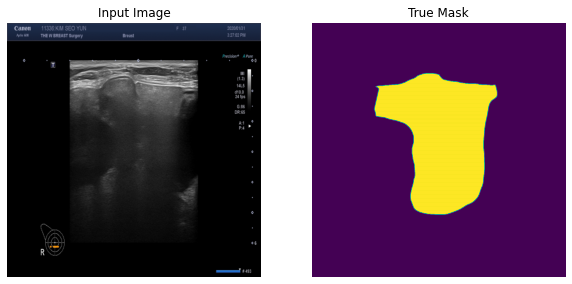

(512, 512, 3) 255
(512, 512, 1) 1.0


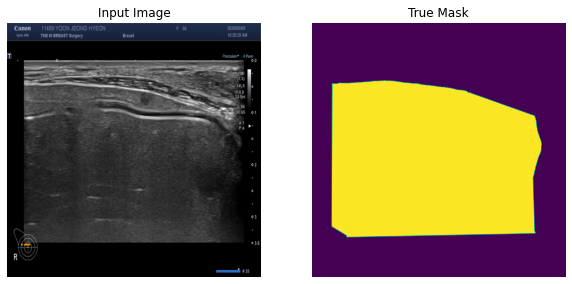

In [79]:
def display(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predict Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow((display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in train_ds.take(10):
    sample_image, sample_mask = image, mask
    print(image.shape, image.numpy().max())
    print(mask.shape, mask.numpy().max())
    
    display([sample_image, sample_mask])

In [11]:
def res_block(inputs,filter_size):
    """
    res_block -- Residual block for building res path
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for residual block
    filter_size {int} -- convolutional filter size 
    
    Returns:
    add {<class 'tensorflow.python.framework.ops.Tensor'>} -- addition of two convolutional filter output  
    """
    # First Conv2D layer
    cb1 = Conv2D(filter_size,(3,3),padding = 'same',activation="relu")(inputs)
    # Second Conv2D layer parallel to the first one
    cb2 = Conv2D(filter_size,(1,1),padding = 'same',activation="relu")(inputs)
    # Addition of cb1 and cb2
    add = Add()([cb1,cb2])
    
    return add

def res_path(inputs,filter_size,path_number):
    """
    res_path -- residual path / modified skip connection
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for res path
    filter_size {int} -- convolutional filter size 
    path_number {int} -- path identifier 
    
    Returns:
    skip_connection {<class 'tensorflow.python.framework.ops.Tensor'>} -- final res path
    """
    # Minimum one residual block for every res path
    skip_connection = res_block(inputs, filter_size)
    
    # Two serial residual blocks for res path 2
    if path_number == 2:
        skip_connection = res_block(skip_connection,filter_size)
    
    # Three serial residual blocks for res path 1
    elif path_number == 1:
        skip_connection = res_block(skip_connection,filter_size)
        skip_connection = res_block(skip_connection,filter_size)
    
    return skip_connection

def decoder_block(inputs, mid_channels, out_channels):
    
    """
    decoder_block -- decoder block formation
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for decoder block
    mid_channels {int} -- no. of mid channels 
    out_channels {int} -- no. of out channels
    
    Returns:
    db {<class 'tensorflow.python.framework.ops.Tensor'>} -- returning the decoder block
    """
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  
    )
    
    # Upsampling (nearest neighbor interpolation) layer
    db = UpSampling2D(size=(2, 2))(inputs)
    # First conv2D layer 
    db = Conv2D(mid_channels, 3, **conv_kwargs)(db)
    # Second conv2D layer
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    return db


    
    
def TransResUNet(input_size=(512, 512, 3)):
    """
    TransResUNet -- main architecture of TransResUNet
    
    Arguments:
    input_size {tuple} -- size of input image
    
    Returns:
    model {<class 'tensorflow.python.keras.engine.training.Model'>} -- final model
    """
    
    # Input 
    inputs = Input(input_size)
    inp = inputs
    input_shape = input_size
    
    # Handling input channels 
    # input with 1 channel will be converted to 3 channels to be compatible with VGG16 pretrained encoder 
    if input_size[-1] < 3:
        inp = Conv2D(3, 1)(inputs)                         
        input_shape = (input_size[0], input_size[0], 3)  
    else:
        inp = inputs
        input_shape = input_size

    # VGG16 with imagenet weights
    encoder = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
       
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inp)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    # Second encoder block
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    # Third encoder block
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)

    # Center block
    center = MaxPooling2D(pool_size=(2, 2))(enc3)
    center = decoder_block(center, 512, 256)

    # Decoder block corresponding to third encoder
    res_path3 = res_path(enc3,128,3)
    dec3 = concatenate([res_path3, center], axis=3)
    dec3 = decoder_block(dec3, 256, 64)
    # Decoder block corresponding to second encoder
    res_path2 = res_path(enc2,64,2)
    dec2 = concatenate([res_path2, dec3], axis=3)
    dec2 = decoder_block(dec2, 128, 64)
    # Final Block concatenation with first encoded feature 
    res_path1 = res_path(enc1,32,1)
    dec1 = concatenate([res_path1, dec2], axis=3)
    dec1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(dec1)
    dec1 = ReLU()(dec1)
    out = Conv2D(3, (1, 1), padding='same')(dec1)
    # Final model
    model = Model(inputs=[inputs], outputs=[out])
    
    return model

In [12]:
EPOCHS = 3
VAL_SUBSPLITS = 5
BUFFER_SIZE = 5
BATCH_SIZE = 3
train_dataset = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_ds.cache().batch(BATCH_SIZE)

In [13]:
model = TransResUNet()
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'],
             )

In [14]:
model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset)

Train for 54 steps, validate for 14 steps
Epoch 1/3
54/54 [==============================] - ETA: 47:18 - loss: 40.0838 - accuracy: 0.45 - ETA: 46:06 - loss: 1039.2590 - accuracy: 0.63 - ETA: 46:45 - loss: 710.7027 - accuracy: 0.6876 - ETA: 45:50 - loss: 537.2761 - accuracy: 0.732 - ETA: 45:46 - loss: 431.2673 - accuracy: 0.766 - ETA: 45:52 - loss: 359.6138 - accuracy: 0.800 - ETA: 44:17 - loss: 308.7335 - accuracy: 0.808 - ETA: 43:38 - loss: 270.2635 - accuracy: 0.819 - ETA: 43:08 - loss: 240.3823 - accuracy: 0.813 - ETA: 41:54 - loss: 216.5029 - accuracy: 0.797 - ETA: 41:22 - loss: 196.8800 - accuracy: 0.804 - ETA: 40:37 - loss: 180.6088 - accuracy: 0.797 - ETA: 39:25 - loss: 166.8292 - accuracy: 0.793 - ETA: 38:50 - loss: 154.9563 - accuracy: 0.798 - ETA: 38:00 - loss: 144.6560 - accuracy: 0.800 - ETA: 36:54 - loss: 135.6522 - accuracy: 0.799 - ETA: 36:10 - loss: 127.7024 - accuracy: 0.798 - ETA: 35:04 - loss: 120.6279 - accuracy: 0.805 - ETA: 34:09 - loss: 114.3109 - accuracy: 0.80

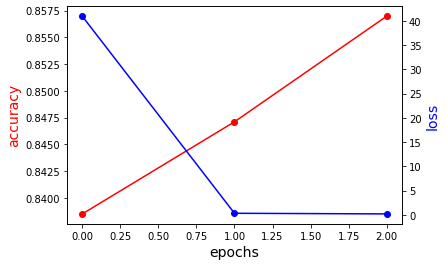

In [42]:
fig,ax = plt.subplots()
# make a plot
ax.plot(model_history.history['accuracy'], label = 'accuracy',color="red", 
        marker="o")
# set x-axis label
ax.set_ylabel("accuracy",
              color="red",
              fontsize=14)
ax.set_xlabel("epochs", fontsize = 14)
# set y-axis label

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(model_history.history['loss'], label = 'loss',color="blue",marker="o")
ax2.set_ylabel("loss",color="blue",fontsize=14)
plt.show()

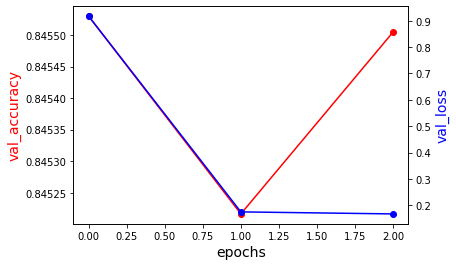

In [43]:
fig,ax = plt.subplots()
# make a plot
ax.plot(model_history.history['val_accuracy'], label = 'accuracy',color="red", 
        marker="o")
# set x-axis label
ax.set_ylabel("val_accuracy",
              color="red",
              fontsize=14)
ax.set_xlabel("epochs", fontsize = 14)
# set y-axis label

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(model_history.history['val_loss'], label = 'loss',color="blue",marker="o")
ax2.set_ylabel("val_loss",color="blue",fontsize=14)
plt.show()

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

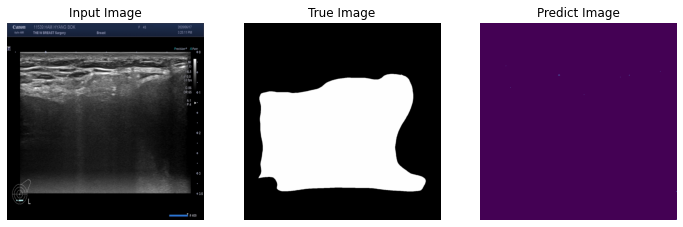

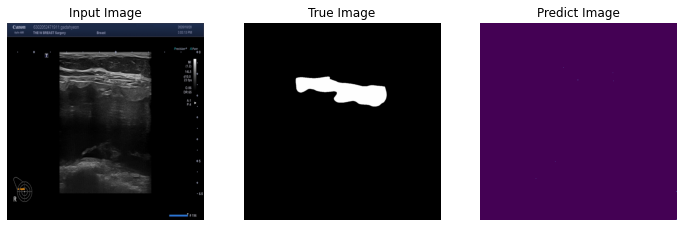

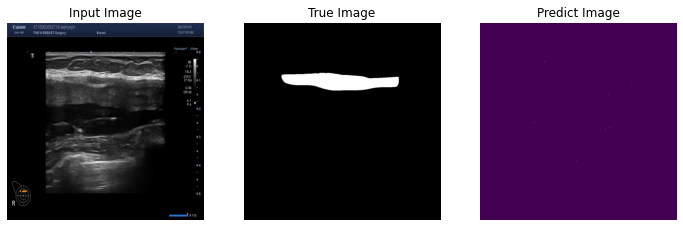

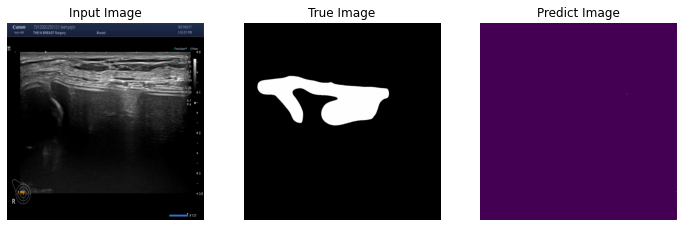

In [52]:
for img_num in [11,14,19,20]:
    test_png_tf = tf.io.read_file(test_x[img_num])
    test_png_np = tf.image.decode_png(test_png_tf, channels=3).numpy()

    norm = np.zeros((512,512,3))
    norm_image = cv2.normalize(test_png_np, norm, 0,255,cv2.NORM_MINMAX) ##희미한 이미지를 또렷하게 하기 위해 정규화 진행.

    test_png_resize_tf = cv2.resize(norm_image, dsize=(512, 512), interpolation=cv2.INTER_LANCZOS4) #

    predicted_mask = model.predict(tf.expand_dims(tf.convert_to_tensor(test_png_resize_tf), axis=0))
    labeled_mask = create_mask(predicted_mask)

    test_png_tf_y = tf.io.read_file(test_y[img_num])
    test_png_np_y = tf.image.decode_png(test_png_tf_y, channels=3).numpy()

    plt.figure(figsize=(12, 12))
    title = ['Input Image', 'True Image', 'Predict Image']
    display_list = [test_png_resize_tf, test_png_np_y, labeled_mask]
    for i in range(3):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow((display_list[i]))
        plt.axis('off')
    plt.show()